# Homework Set 5
### James Graham - N11252710

-------------------------------------------------

In this homework, we look to replicate exactly the previous AR(1) simulation and bias checking code, but using Julia instead of Python. Briefly, recall that the AR(1) process is given by

$$ X_{t+1} = \beta + \alpha X_t + \sigma W_{t+1}, \ \{ W_t \} \sim N(0,1) $$

The following cell imports the libraries we'll need, defines the set of $\alpha$ parameters, and the set of observations, $n$. I set $\beta=0$, for convenience, and $M=10000$ is the number of simulations. 

In [3]:
using Distributions

In [4]:
a = linspace(0.5,0.9,5)
n = linspace(50,500,10)
n = round(Int64,n)             # convert np.array float-type to int-type
b = 0
M = 10000

10000

The following cell defines the AR(1) simulation function. 

In [5]:
function ar1_sim(n, b, a, W)
    x = Array(Float64,n)
    x[1] = 1 
    for t = 1:n-1
        x[t+1] = b + a*x[t] + W[t+1]
    end
    
    return x
end


ar1_sim (generic function with 1 method)

The following cell defines a linear regression coefficient computation function.

In [6]:
function ar1_regress(n, b, a, W)
    x = ar1_sim(n, b, a, W)
    xmean   = mean(x)
    var_xx  = 0
    cov_xx1 =0
    for t = 1:n-1
        var_xx  += (x[t] - xmean)*(x[t] - xmean)
        cov_xx1 += (x[t] - xmean)*(x[t+1] - xmean)
    end
    var_xx = var_xx/(n-1)
    cov_xx1 = cov_xx1/(n-1)
    ahat = cov_xx1/var_xx
    return ahat
end

ar1_regress (generic function with 1 method)

Now we implement the loop over the functions that will compute the average OLS coefficients. Note, we loop over true coefficient values, $a$, over sample lengths, $n$, and over simulation numbers, $M$. We take the average over simulations to get a measure of the bias of the OLS procedure. 

Note, I have included the <code>@parallel</code> command to allow for parallel processing of the for loop. On it's second run, the <code>@time</code> function claims that the loop runs in less than a second. However, the output of the function takes several seconds to become available. I suspect this may be because I am not using the <code>@time</code> function properly (perhaps it is only referring to the call for <code>@parallel</code>). Nevertheless, the parallelization appears to spead the process up relative to not including it in the code. 


In [7]:
bias = Array(Float64,length(a),length(n)) 
                          
@time for a_i = 1:length(a)
    for n_i = 1:length(n)
        #W = np.empty((n[n_i],M))
        #W = randn(n[n_i],M)
        ahattmp = 0
        #ahat = 0
        
        for m = 1:M
            W = Array(Float64,n[n_i]) 
            W = randn(n[n_i],1)
            ahattmp += ar1_regress(n[n_i], b, a[a_i], W)
        end
        ahat = ahattmp/M    
        bias[a_i, n_i] = ahat - a[a_i]
    end
end

 12.997797 seconds (553.49 M allocations: 11.459 GB, 8.98% gc time)


Finally, we plot the bias for each sample size and value of the true AR(1) coefficient:

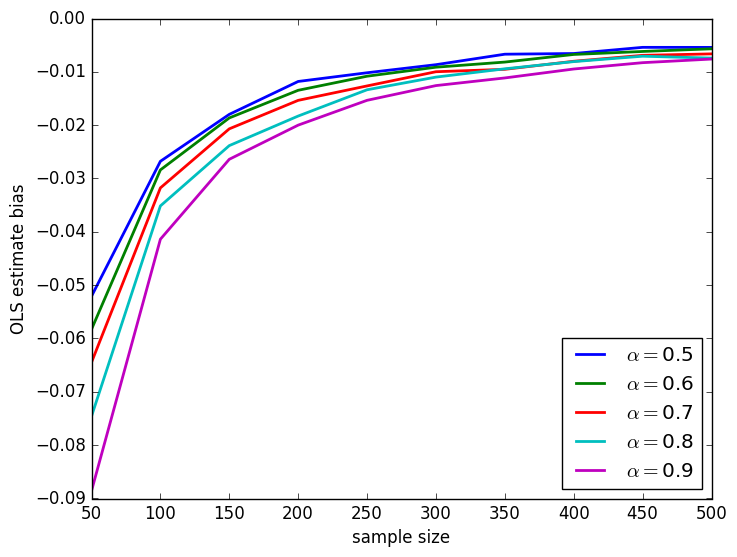

PyObject <matplotlib.text.Text object at 0x7f89c9e80518>

In [9]:
using PyPlot

for a_i=1:length(a)
    current_label = string(L"$\alpha=$", a[a_i])
    plot(n, vec(bias[a_i,:]), linewidth=2.0, label=current_label)
end
legend(loc="lower right")
xlabel("sample size")
ylabel("OLS estimate bias")